In [1]:
rm(list = ls())
options(stringsAsFactors = F)
gc()

library(dplyr)
library(Seurat)
library(patchwork)
library(ggplot2)
library(DoubletFinder)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,595865,31.9,1271077,67.9,1271077,67.9
Vcells,1065105,8.2,8388608,64.0,1649361,12.6


Warning message:
"程辑包'dplyr'是用R版本4.1.3 来建造的"

载入程辑包：'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"程辑包'Seurat'是用R版本4.1.3 来建造的"
Attaching SeuratObject

Attaching sp

Warning message:
"程辑包'patchwork'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'ggplot2'是用R版本4.1.3 来建造的"


In [2]:
sc <- "./00.data/03.single cell/"
metadata <- './00.data/03.single cell/GSE125449_Set1_samples.txt'

sce <- Read10X(data.dir = sc)
metadata <- read.table(metadata,
                       sep = '\t',header = T)
same <- intersect(metadata[,2],colnames(sce))
sce <- sce[,same]
rownames(metadata) <- metadata[,2]
sce.all <- CreateSeuratObject(counts = sce,  
                              min.cells = 3,
                              min.features = 200) 
sce.all  <- AddMetaData(object = sce.all, metadata = metadata)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [3]:
mito_genes=rownames(sce.all)[grep("^MT-", rownames(sce.all))] 
sce.all[["percent.mt"]] <- PercentageFeatureSet(sce.all, pattern = "^MT-.")
sce.all=PercentageFeatureSet(sce.all, "^MT-", col.name = "percent_mt")
fivenum(sce.all@meta.data$percent_mt)

[1]  0.03977725  1.76399027  3.26306677  5.49763033 89.76454145

In [4]:
ribo_genes=rownames(sce.all)[grep("^Rp[sl]", rownames(sce.all),ignore.case = T)]
ribo_genes
sce.all=PercentageFeatureSet(sce.all, "^RP[SL]", col.name = "percent_ribo")
fivenum(sce.all@meta.data$percent_ribo)

[1] "RPL22"          "RPL11"          "RPS6KA1"        "RPS8"          
  [5] "RPL5"           "RPS27"          "RPS6KC1"        "RPS7"          
  [9] "RPS27A"         "RPL31"          "RPL37A"         "RPL32"         
 [13] "RPL15"          "RPSA"           "RPL14"          "RPL29"         
 [17] "RPL24"          "RPL22L1"        "RPL39L"         "RPL35A"        
 [21] "RPL9"           "RPL34-AS1"      "RPL34"          "RPS3A"         
 [25] "RPL37"          "RPS23"          "RPS14"          "RPL26L1"       
 [29] "RPS18"          "RPS10"          "RPL10A"         "RPL7L1"        
 [33] "RPS12"          "RPS6KA2"        "RPS6KA3"        "RPS4X"         
 [37] "RPS6KA6"        "RPL36A"         "RPL39"          "RPL10"         
 [41] "RPS20"          "RPL7"           "RPL30"          "RPL8"          
 [45] "RPS6"           "RPL35"          "RPL12"          "RPL7A"         
 [49] "RPLP2"          "RPL27A"         "RPS13"          "RPS6KA4"       
 [53] "RPS6KB2"        "RPS3"           "RPS25"          "RPS24"         
 [57] "RPS26"          "RPL41"          "RPL6"           "RPLP0"         
 [61] "RPL21"          "RPL10L"         "RPS29"          "RPL36AL"       
 [65] "RPS6KL1"        "RPS6KA5"        "RPS27L"         "RPL4"          
 [69] "RPLP1"          "RPS17"          "RPL3L"          "RPS2"          
 [73] "RPS15A"         "RPL13"          "RPL26"          "RPL23A"        
 [77] "RPL23"          "RPL19"          "RPL27"          "RPS6KB1"       
 [81] "RPL38"          "RPL17-C18orf32" "RPL17"          "RPS21"         
 [85] "RPS15"          "RPL36"          "RPS28"          "RPL18A"        
 [89] "RPS16"          "RPS19"          "RPL18"          "RPL13A"        
 [93] "RPS11"          "RPS9"           "RPL28"          "RPS5"          
 [97] "RPS4Y1"         "RPS4Y2"         "RPL3"           "RPS19BP1"

[1]  0.9277298  9.7345724 16.1219945 22.4274787 54.2625169

In [5]:
rownames(sce.all)[grep("^Hb[^(p)]", rownames(sce.all),ignore.case = T)]
sce.all=PercentageFeatureSet(sce.all, "^HB[^(P)]", col.name = "percent_hb")
fivenum(sce.all@meta.data$percent_hb)

[1] "HBEGF" "HBS1L" "HBB"   "HBD"   "HBG2"  "HBZ"   "HBM"   "HBA2"  "HBA1" 
[10] "HBQ1"

[1]  0.00000000  0.00000000  0.00000000  0.01580778 60.46852123

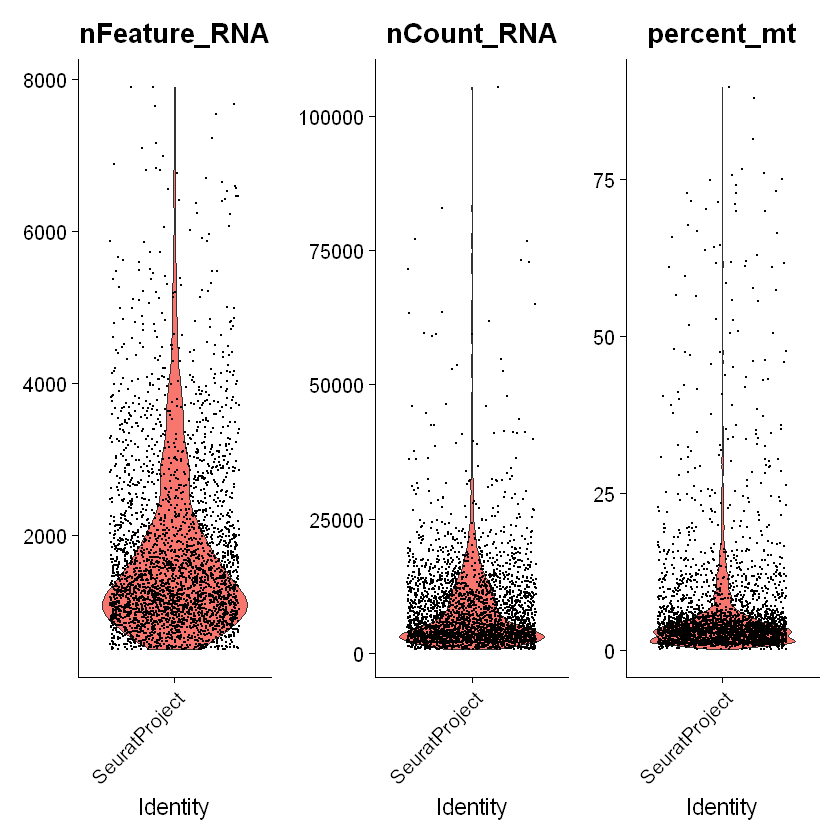

In [6]:
VlnPlot(object = sce.all,features = c("nFeature_RNA", "nCount_RNA", "percent_mt"), ncol = 3)

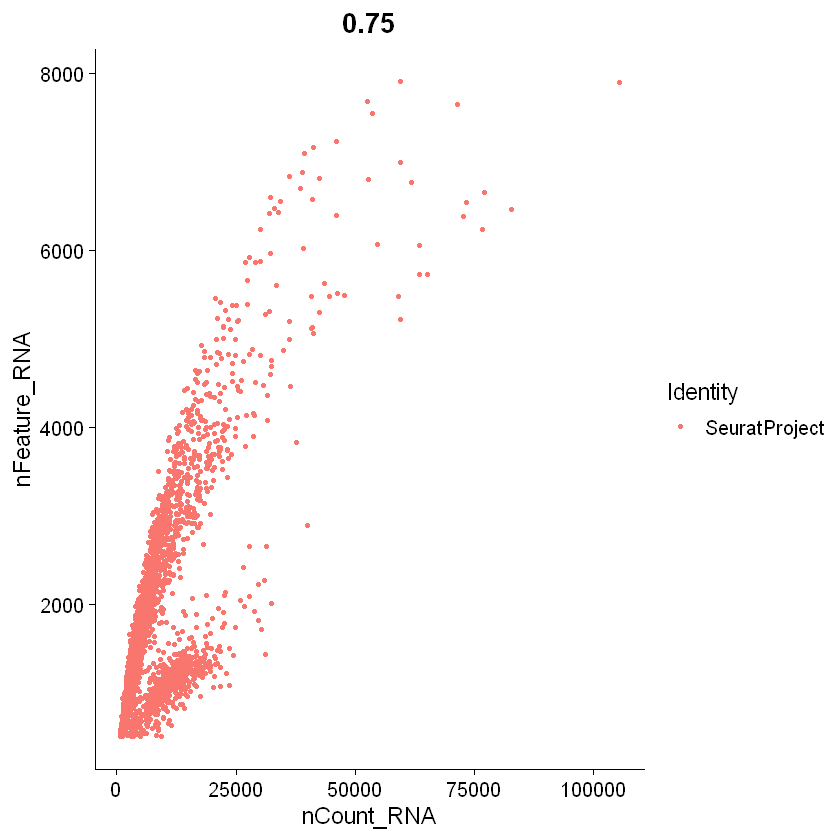

In [14]:
FeatureScatter(sce.all, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

In [12]:
selected_c <- WhichCells(sce.all, expression = nFeature_RNA > 700)
selected_f <- rownames(sce.all)[Matrix::rowSums(sce.all@assays$RNA@counts > 0 ) > 3]
sce.all.filt <- subset(sce.all, features = selected_f, cells = selected_c)
dim(sce.all.filt) 

selected_mito <- WhichCells(sce.all.filt, expression = percent_mt < 20)
sce.all.filt <- subset(sce.all.filt, cells = selected_mito)
dim(sce.all.filt)

[1] 19106  2835

[1] 19106  2719

In [16]:
sce.all.filt<- NormalizeData(sce.all.filt, normalization.method = "LogNormalize", scale.factor = 10000)
sce.all.filt <- FindVariableFeatures(sce.all.filt, selection.method = "vst", nfeatures = 2000) 

In [18]:
top10 <- head(VariableFeatures(sce.all.filt), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(sce.all.filt)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)

When using repel, set xnudge and ynudge to 0 for optimal results



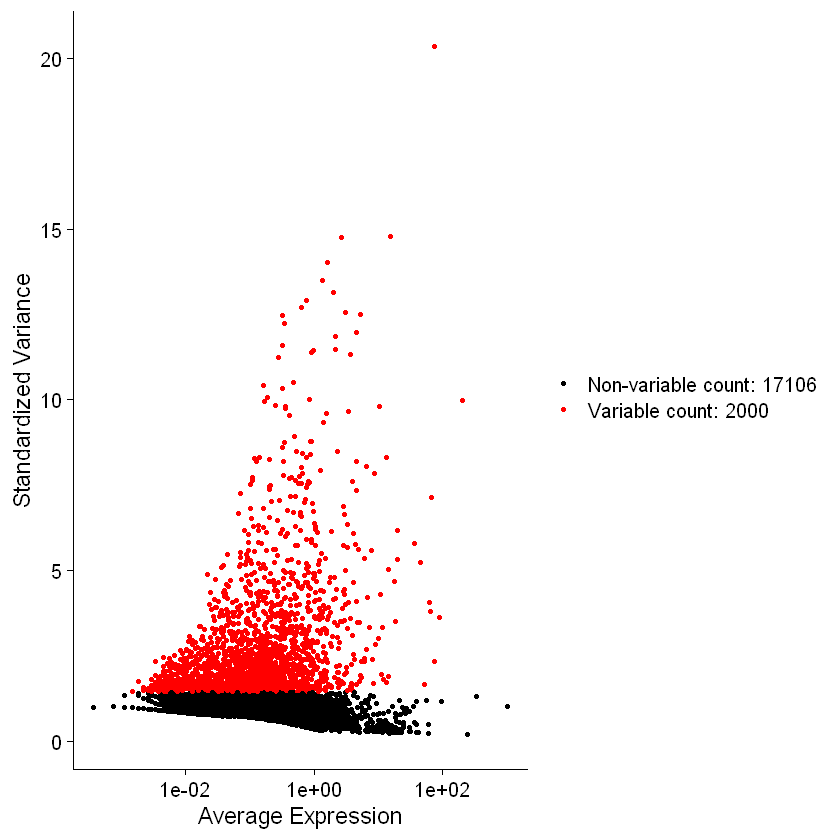

In [19]:
plot1

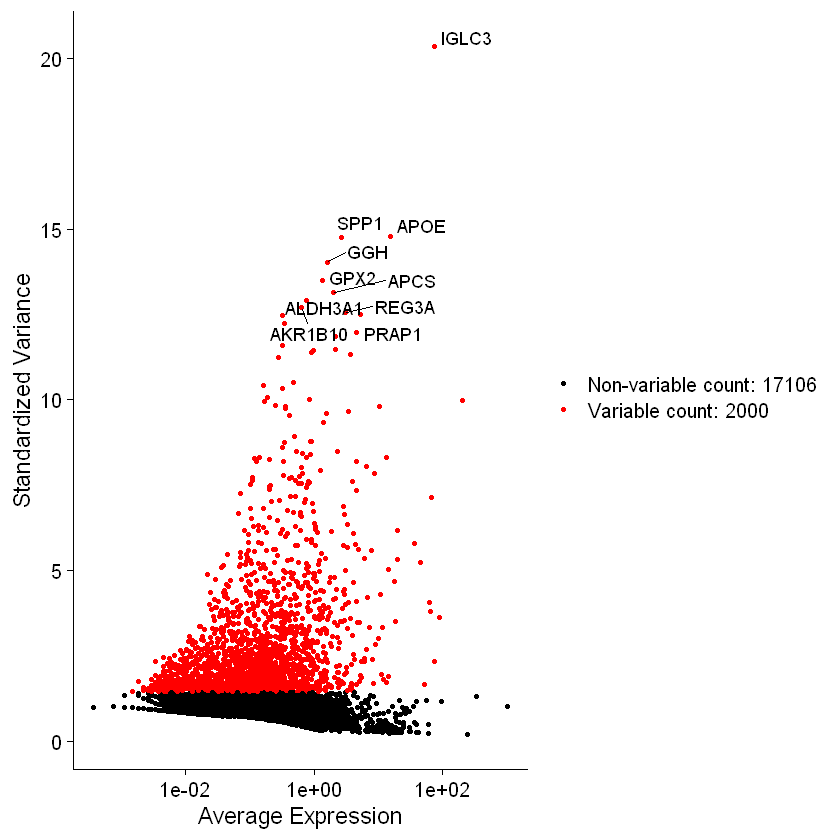

In [20]:
plot2

Centering and scaling data matrix



TYMS    HELLS     GMNN     RRM2    HMGB2     CDK1   NUSAP1    UBE2C 
  "TYMS"  "HELLS"   "GMNN"   "RRM2"  "HMGB2"   "CDK1" "NUSAP1"  "UBE2C" 
   BIRC5     TPX2    TOP2A     NUF2    MKI67    CENPF    CCNB2    AURKB 
 "BIRC5"   "TPX2"  "TOP2A"   "NUF2"  "MKI67"  "CENPF"  "CCNB2"  "AURKB" 
   GTSE1    CDC20   DLGAP5    CDCA8    KIF23     HMMR     NEK2    CENPA 
 "GTSE1"  "CDC20" "DLGAP5"  "CDCA8"  "KIF23"   "HMMR"   "NEK2"  "CENPA"

Warning message in irlba(A = t(x = object), nv = npcs, ...):
"You're computing too large a percentage of total singular values, use a standard svd instead."
PC_ 1 
Positive:  MKI67, UBE2C, TOP2A, NUSAP1, CENPF, BIRC5, CDK1, TPX2, RRM2, TYMS 
	   GTSE1, HMMR, AURKB, HMGB2, NUF2, CENPE, CDC20, DLGAP5, TMPO, CENPA 
	   KIF2C, CKS1B, CDCA8, KIF20B, CCNB2, SMC4, ATAD2, AURKA, BUB1, CDCA3 
Negative:  TIPIN, UBR7, UNG, EXO1, CASP8AP2, GAS2L3, CHAF1B, POLD3, BRIP1, DSCC1 
	   PSRC1, BLM, G2E3, RANGAP1, POLA1, RFC2, MSH2, CDC25C, RPA2, CCNE2 
	   TUBB4B, NCAPD2, CKAP5, RAD51, WDR76, NASP, MCM6, FAM64A, MCM4, PRIM1 
PC_ 2 
Positive:  CDC20, HMMR, CCNB2, UBE2C, TOP2A, GTSE1, TPX2, AURKA, NEK2, CENPE 
	   CENPA, AURKB, ANLN, BIRC5, DLGAP5, CDCA8, CENPF, KIF23, FAM64A, KIF20B 
	   TTK, HJURP, ECT2, CDCA2, CDCA3, BUB1, CDC25C, NUF2, PSRC1, GAS2L3 
Negative:  GINS2, PCNA, HELLS, MCM5, MCM2, CLSPN, TYMS, UHRF1, FEN1, CDC45 
	   DTL, SLBP, CDCA7, NASP, MCM4, MCM6, WDR76, RRM1, ATAD2, RRM2 
	   RAD51, U

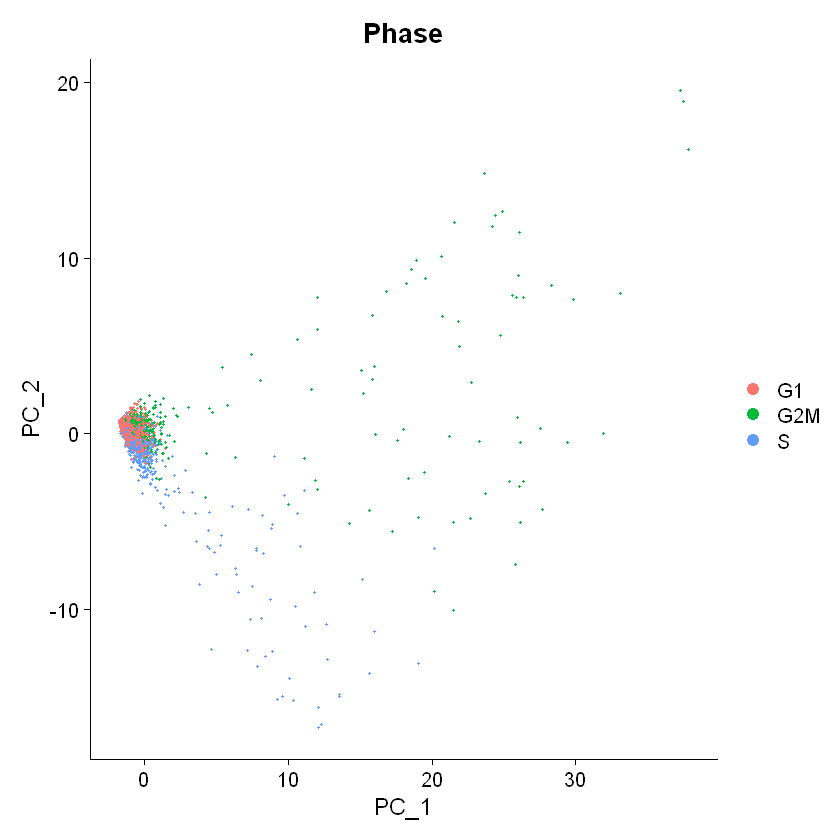

In [21]:
scale.genes <-  rownames(sce.all.filt)
sce.all.filt <- ScaleData(sce.all.filt, features = scale.genes)

CaseMatch(c(cc.genes$s.genes,cc.genes$g2m.genes),VariableFeatures(sce.all.filt))
g2m_genes = cc.genes$g2m.genes
g2m_genes = CaseMatch(search = g2m_genes, match = rownames(sce.all.filt))
s_genes = cc.genes$s.genes
s_genes = CaseMatch(search = s_genes, match = rownames(sce.all.filt))
sce.all.filt <- CellCycleScoring(object=sce.all.filt,  g2m.features=g2m_genes,  s.features=s_genes)
scRNAa <- RunPCA(sce.all.filt, features = c(s_genes, g2m_genes))
DimPlot(scRNAa, reduction = "pca", group.by = "Phase")
sce.all.filt = RunPCA(sce.all.filt, npcs = 20)

In [22]:
nExp <- round(ncol(sce.all.filt) * 0.04)
sce.all.filt <- doubletFinder_v3(sce.all.filt, pN = 0.25, pK = 0.09, nExp = nExp, PCs = 1:20)
sce.all.filt=FindNeighbors(sce.all.filt, dims = 1:20, k.param = 60, prune.SNN = 1/15)
for (res in c(0.01, 0.05, 0.1, 0.2, 0.3, 0.5,0.8,1)) {
  sce.all.filt=FindClusters(sce.all.filt, graph.name = "RNA_snn", resolution = res, algorithm = 1)
}
apply(sce.all.filt@meta.data[,grep("RNA_snn_res",colnames(sce.all.filt@meta.data))],2,table)
sce.all.filt <- FindClusters(sce.all.filt, resolution = 0.8)
table(sce.all.filt@meta.data$seurat_clusters)
metadata <- sce.all.filt@meta.data
cell_cluster <- data.frame(cell_ID=rownames(metadata), cluster_ID=metadata$seurat_clusters)


载入需要的程辑包：fields

Warning message:
"程辑包'fields'是用R版本4.1.3 来建造的"
载入需要的程辑包：spam

Warning message:
"程辑包'spam'是用R版本4.1.3 来建造的"
Spam version 2.9-0 (2022-07-11) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


载入程辑包：'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


载入需要的程辑包：viridis

Warning message:
"程辑包'viridis'是用R版本4.1.3 来建造的"
载入需要的程辑包：viridisLite

Warning message:
"程辑包'viridisLite'是用R版本4.1.3 来建造的"

Try help(fields) to get started.

载入需要的程辑包：KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



[1] "Creating 906 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2719
Number of edges: 231309

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9958
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2719
Number of edges: 231309

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9865
Number of communities: 6
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2719
Number of edges: 231309

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9779
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2719
Number of edges: 231309

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9609
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer

$RNA_snn_res.0.01

   0    1    2    3    4 
1176  726  437  274  106 

$RNA_snn_res.0.05

  0   1   2   3   4   5 
726 671 505 437 274 106 

$RNA_snn_res.0.1

  0   1   2   3   4   5   6 
671 522 505 437 274 204 106 

$RNA_snn_res.0.2

  0   1   2   3   4   5   6 
671 522 505 437 274 204 106 

$RNA_snn_res.0.3

  0   1   2   3   4   5   6 
671 522 505 437 274 204 106 

$RNA_snn_res.0.5

  0   1   2   3   4   5   6   7   8 
505 437 391 322 280 274 204 200 106 

$RNA_snn_res.0.8

  0   1   2   3   4   5   6   7   8 
505 437 391 321 280 274 204 201 106 

$RNA_snn_res.1

  0   1   2   3   4   5   6   7   8   9 
437 390 320 280 274 266 240 204 202 106 


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2719
Number of edges: 231309

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8743
Number of communities: 9
Elapsed time: 0 seconds



  0   1   2   3   4   5   6   7   8 
505 437 391 321 280 274 204 201 106 

In [23]:
scRNA <- RunPCA(sce.all.filt, features = VariableFeatures(sce.all.filt),npcs = 100) 
scRNA <- JackStraw(scRNA, num.replicate = 100, dims = 100)
scRNA<- ScoreJackStraw(scRNA, dims = 1:100)

PC_ 1 
Positive:  TF, FGA, APOC2, RBP4, SERPINC1, HPX, APOH, FGG, APOB, AMBP 
	   AHSG, GC, FGB, VTN, KNG1, ALB, HP, ASGR2, ANGPTL3, ANG 
	   HSD17B6, C3, ASGR1, BAAT, F2, C4BPB, TTR, CPB2, AZGP1, APOC1 
Negative:  S100A6, IGHG4, SOCS3, RGS1, IGHG1, MZB1, IGHGP, IGHG2, IGFBP7, NR4A1 
	   IGLC2, JCHAIN, IGLC3, CD74, DERL3, WT1-AS, CORO1A, CD27, IGKV1-12, PTP4A3 
	   SPRY1, MGP, IGHM, DNAJA4, IGKV1-5, GJA4, TIMP1, LTB, CLEC14A, CD69 
PC_ 2 
Positive:  MGP, PLPP1, IFI27, IGFBP7, TM4SF1, TIMP3, RAMP2, CLEC14A, EMP1, ID1 
	   HYAL2, SPRY1, SLC9A3R2, EMCN, CLDN5, FLT1, RBP7, NOTCH4, CD34, PLVAP 
	   PODXL, PTPRB, ADGRL4, ADGRF5, AQP1, ADAMTS1, GJA4, EFNB2, SOCS3, WWTR1 
Negative:  RGS1, IGHG4, IGHG1, MZB1, IGHGP, IGHG2, IGLC2, JCHAIN, CORO1A, DERL3 
	   IGLC3, CD27, WT1-AS, ITGB2, GPR183, IGKV1-12, CTSS, IGKV1-5, IGHM, UCP2 
	   HLA-DQA1, TRAC, CD69, IGLV3-1, HLA-DPB1, LTB, PTPN7, RGS10, HLA-DPA1, LST1 
PC_ 3 
Positive:  RAMP2, CLEC14A, EMCN, FLT1, RBP7, PLVAP, NOTCH4, PODXL, CD93, SLC9A3R2 

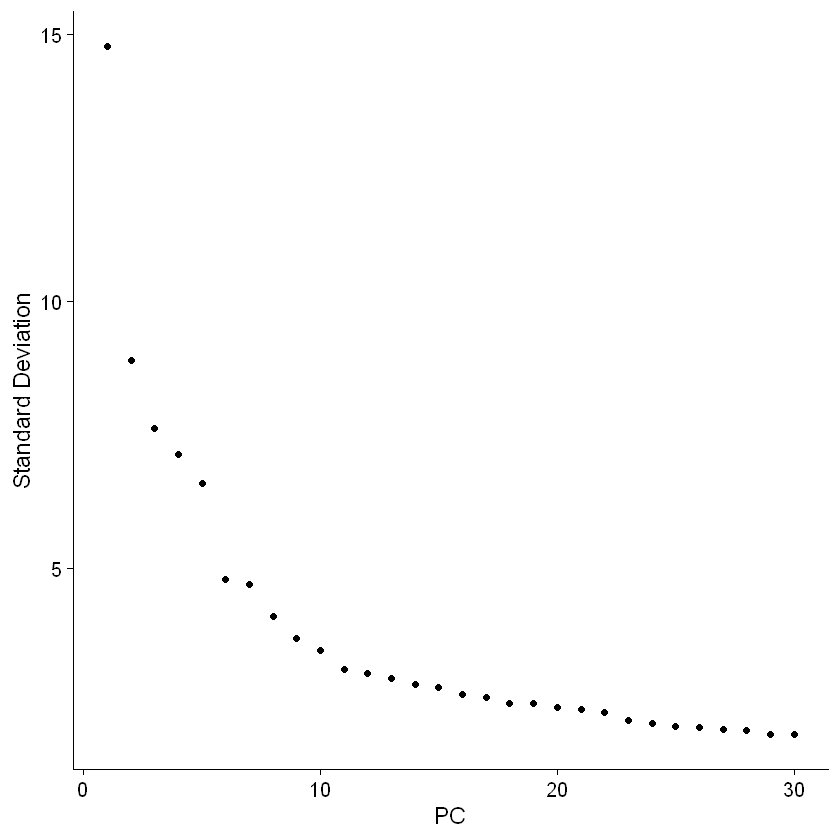

In [25]:
ElbowPlot(scRNA, ndims=30, reduction="pca") 

Warning message:
"Removed 42903 rows containing missing values (geom_point)."


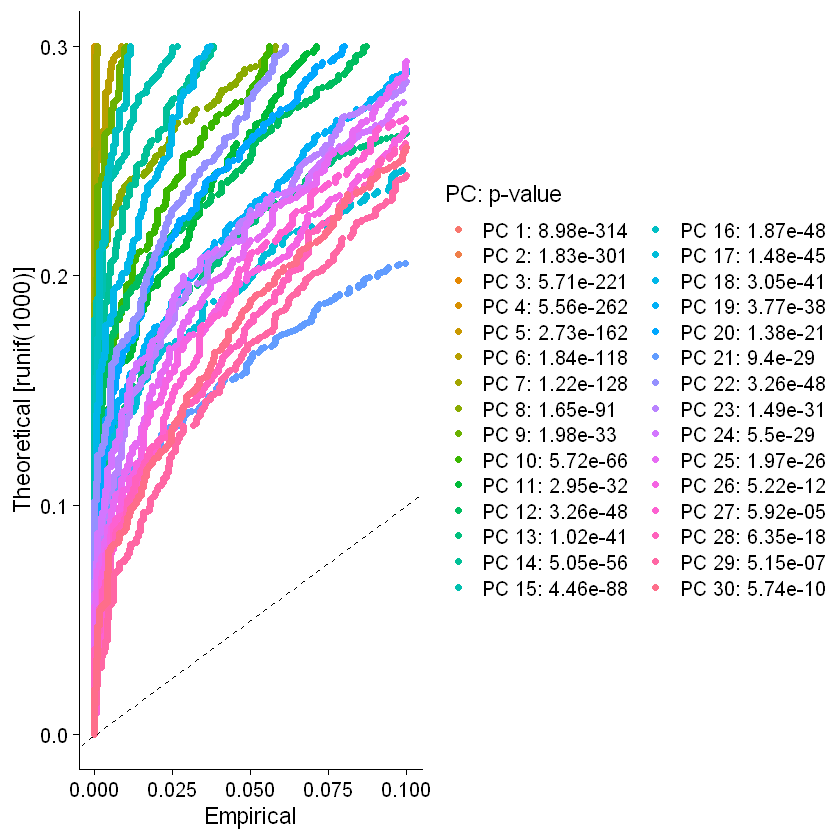

In [27]:
JackStrawPlot(scRNA, dims = 1:30)

In [28]:
pc.num=1:20
sce.all.filt = RunTSNE(sce.all.filt, dims = pc.num)

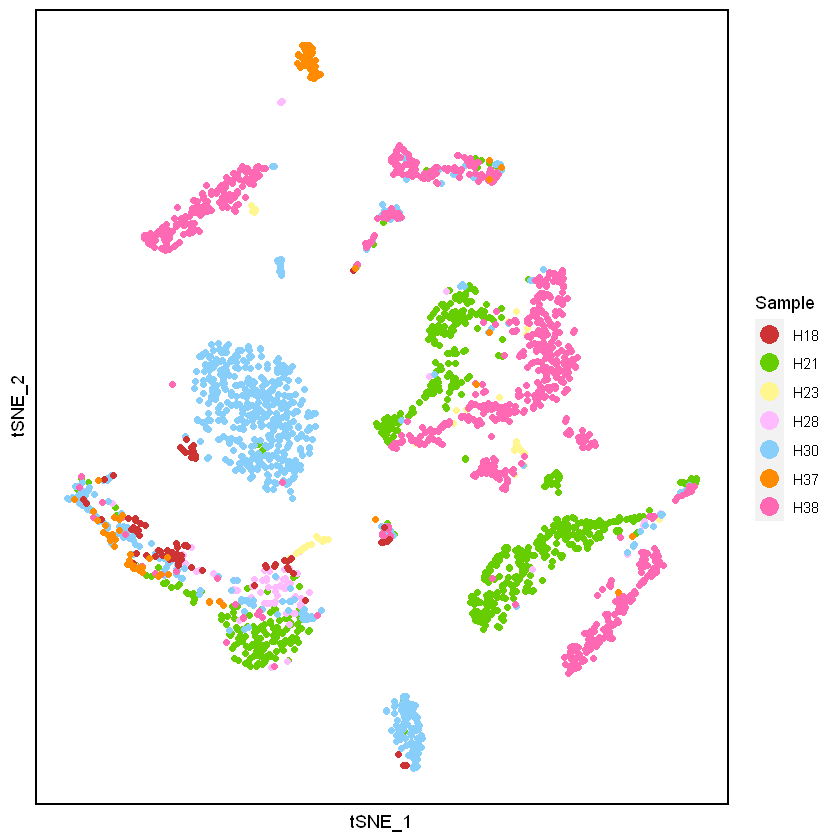

In [29]:
mydata<- FetchData(sce.all.filt,vars = c("tSNE_1","tSNE_2","Sample"))
ggplot(mydata,aes(x= tSNE_1 , y = tSNE_2 ,color = Sample)) +geom_point(size = 1 , alpha =1 )+ 
  geom_point(size = 1.5, alpha = 1) + 
  scale_color_manual(values=c("brown3", "chartreuse3", "khaki1", "plum1", "lightskyblue", "darkorange", "hotpink",  "seashell3", "lightblue2"))+
  guides(colour=guide_legend(override.aes=list(size=5)))+ 
  theme(axis.text.y = element_blank(),   
        axis.ticks.y = element_blank(),   
        axis.text.x = element_blank(),  
        axis.ticks.x = element_blank())+  
  theme(panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"),
        panel.background = element_rect(fill = "white"))

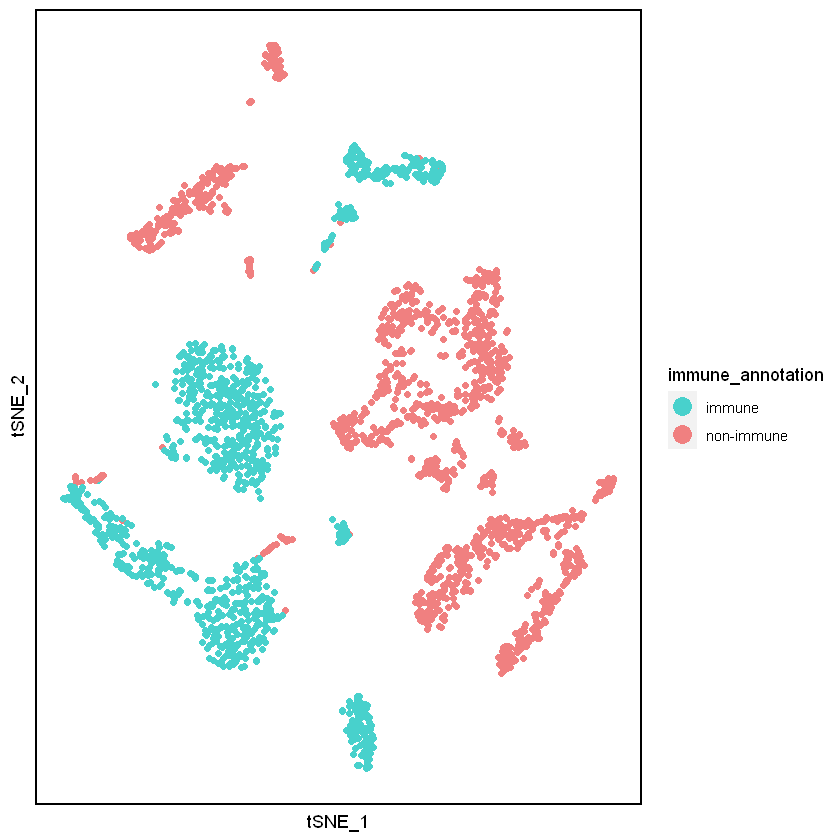

In [30]:
immune <- c("B cell","T cell","TAM")
sce <- sce.all.filt
sce@meta.data$immune_annotation <-ifelse(sce@meta.data$Type %in% immune ,'immune','non-immune')
mydata<- FetchData(sce,vars = c("tSNE_1","tSNE_2","immune_annotation"))
ggplot(mydata,aes(x= tSNE_1 , y = tSNE_2 ,color = immune_annotation)) +geom_point(size = 1 , alpha =1 )+ 
  geom_point(size = 1.5, alpha = 1) + 
  scale_color_manual(values=c("#48D1CC", "#F08080"))+
  guides(colour=guide_legend(override.aes=list(size=5)))+ 
  theme(axis.text.y = element_blank(),   
        axis.ticks.y = element_blank(),   
        axis.text.x = element_blank(),  
        axis.ticks.x = element_blank())+ 
  theme(panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"),
        panel.background = element_rect(fill = "white"))

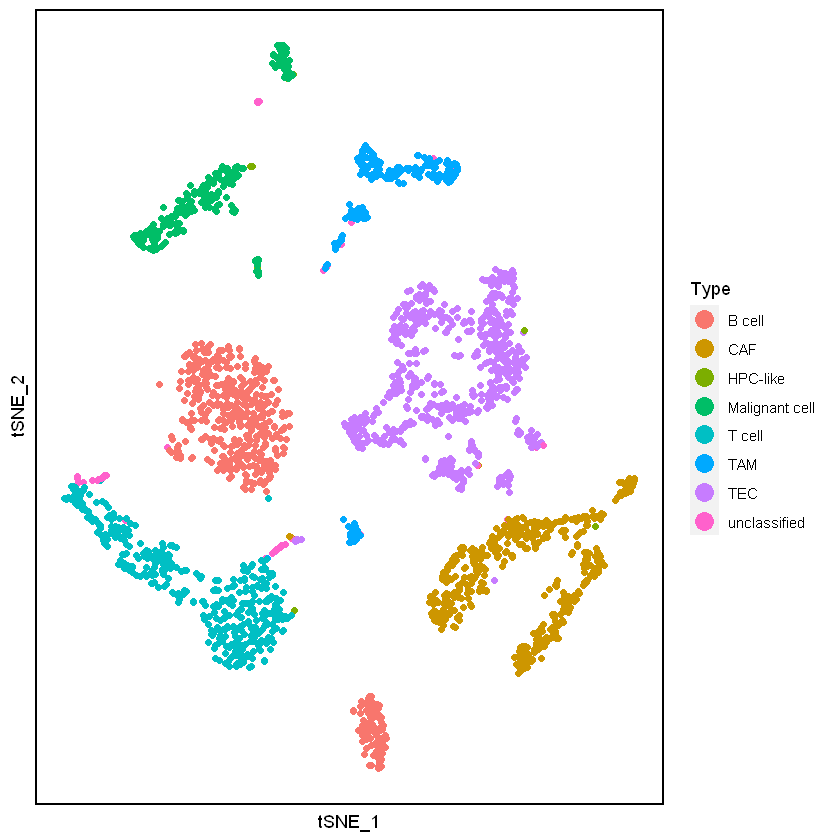

In [31]:
mydata<- FetchData(sce,vars = c("tSNE_1","tSNE_2","Type"))
ggplot(mydata,aes(x= tSNE_1 , y = tSNE_2 ,color = Type)) +geom_point(size = 1 , alpha =1 )+ 
  geom_point(size = 1.5, alpha = 1) + 
  guides(colour=guide_legend(override.aes=list(size=5)))+ 
  theme(axis.text.y = element_blank(),   
        axis.ticks.y = element_blank(),   
        axis.text.x = element_blank(),   
        axis.ticks.x = element_blank())+  
  theme(panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"),
        panel.background = element_rect(fill = "white")) 

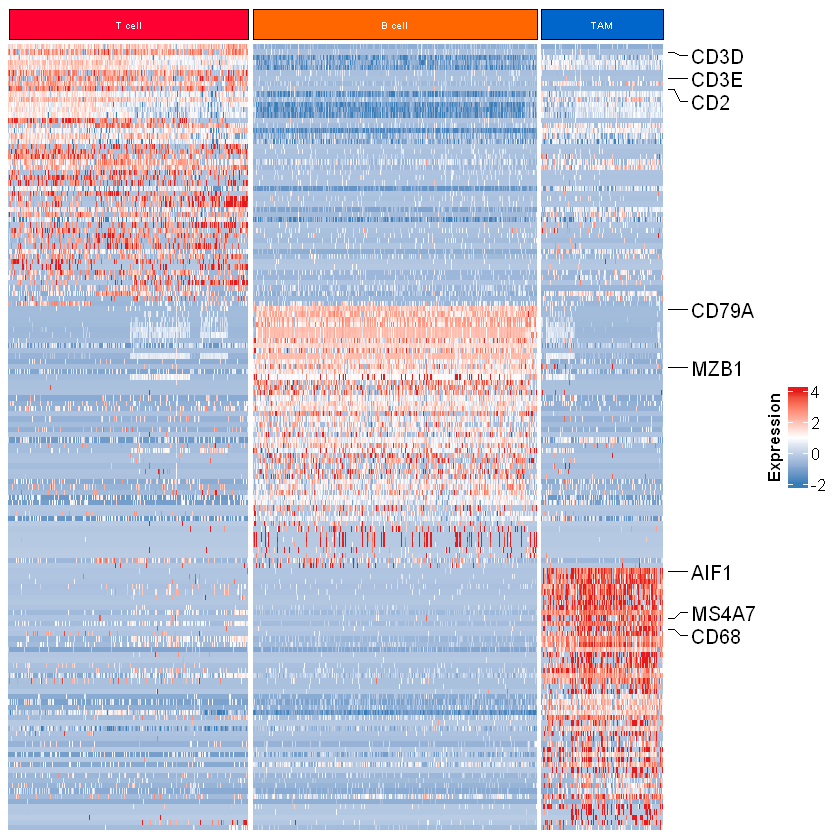

In [37]:
scRNA$Type <- factor(x = scRNA$Type, levels = c('T cell','B cell','TAM'))  
library(ComplexHeatmap)
col <- c('#FF0033','#FF6600','#0066CC')
mat <- GetAssayData(scRNA,slot = 'scale.data')
gene_features <- top10
cluster_info <- sort(scRNA$Type)
names(col) <- levels(cluster_info)
mat <- as.matrix(mat[top10$gene,names(cluster_info)])
gene <- c('CD3D','CD3E','CD2','CD79A','MZB1',"AIF1","MS4A7","CD68")
gene_pos <- which(rownames(mat)%in%gene)
row_anno <- rowAnnotation(gene=anno_mark(at=gene_pos,labels = gene))
top_anno <- HeatmapAnnotation(cluster=anno_block(gp=gpar(fill=col),
                                                 labels = levels(cluster_info),
                                                 labels_gp = gpar(cex=0.5,col='white')))
col_fun = colorRamp2(c(-2, 1, 4), c("#377EB8", "white", "#E41A1C"))
Heatmap(mat,
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        show_column_names = FALSE,
        show_row_names = FALSE,
        column_split = cluster_info,
        top_annotation = top_anno, #
        column_title = NULL,
        right_annotation = row_anno,
        heatmap_legend_param = list(
          title='Expression',
          title_position='leftcenter-rot'),
        col = col_fun)